In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("datasetfootball.csv")


/tmp/ipython-input-2284886932.py:1: DtypeWarning: Columns (0,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("datasetfootball.csv")


In [3]:
print("Dataset Shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))

Dataset Shape: (1048575, 13)

First 10 rows:
    appearance_id    game_id  player_id  player_club_id  \
0   2231978_38004  2231978.0    38004.0           853.0   
1   2233748_79232  2233748.0    79232.0          8841.0   
2   2234413_42792  2234413.0    42792.0          6251.0   
3   2234418_73333  2234418.0    73333.0          1274.0   
4  2234421_122011  2234421.0   122011.0           195.0   
5  2234421_146889  2234421.0   146889.0           195.0   
6   2235539_28716  2235539.0    28716.0           282.0   
7   2235539_69445  2235539.0    69445.0           282.0   
8   2235545_19409  2235545.0    19409.0           317.0   
9   2235545_30003  2235545.0    30003.0           317.0   

   player_current_club_id        date       player_name competition_id  \
0                   235.0  03-07-2012  Aurélien Joachim            CLQ   
1                  2698.0  05-07-2012    Ruslan Abyshov            ELQ   
2                   465.0  05-07-2012       Sander Puri            ELQ   
3        

In [4]:
# Remove columns with too many missing values or not useful for prediction
df = df.drop(['appearance_id', 'game_id', 'player_id', 'player_club_id',
              'player_current_club_id', 'date', 'player_name', 'competition_id'], axis=1)

In [5]:
# Remove rows with missing values
print("\nMissing Values Before:")
print(df.isna().sum())

df = df.dropna()

print("\nMissing Values After:")
print(df.isna().sum())

print("\nDataset Shape After Cleaning:", df.shape)



Missing Values Before:
yellow_cards      1043522
red_cards         1043522
goals             1043522
assists           1043522
minutes_played    1043522
dtype: int64

Missing Values After:
yellow_cards      0
red_cards         0
goals             0
assists           0
minutes_played    0
dtype: int64

Dataset Shape After Cleaning: (5053, 5)


In [6]:
# Create a classification target: "Player Performance Category"
# Based on goals scored: Low (0), Medium (1-2), High (3+)
def categorize_performance(goals):
    if goals == 0:
        return 'Low'
    elif goals <= 2:
        return 'Medium'
    else:
        return 'High'

df['Performance'] = df['goals'].apply(categorize_performance)

print("\nTarget distribution:\n", df["Performance"].value_counts())



Target distribution:
 Performance
Low       4544
Medium     506
High         3
Name: count, dtype: int64


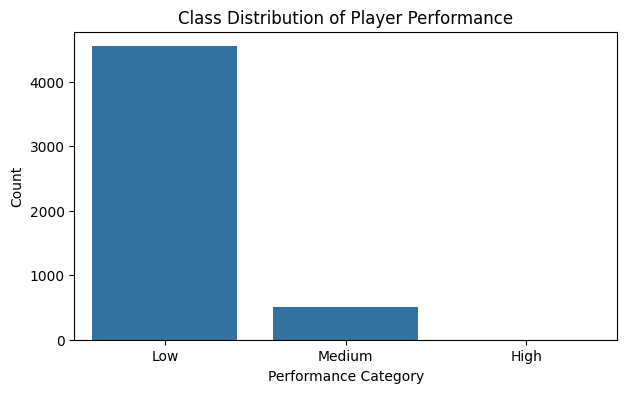

In [7]:
# Class distribution
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Performance', order=['Low', 'Medium', 'High'])
plt.title("Class Distribution of Player Performance")
plt.xlabel("Performance Category")
plt.ylabel("Count")
plt.show()

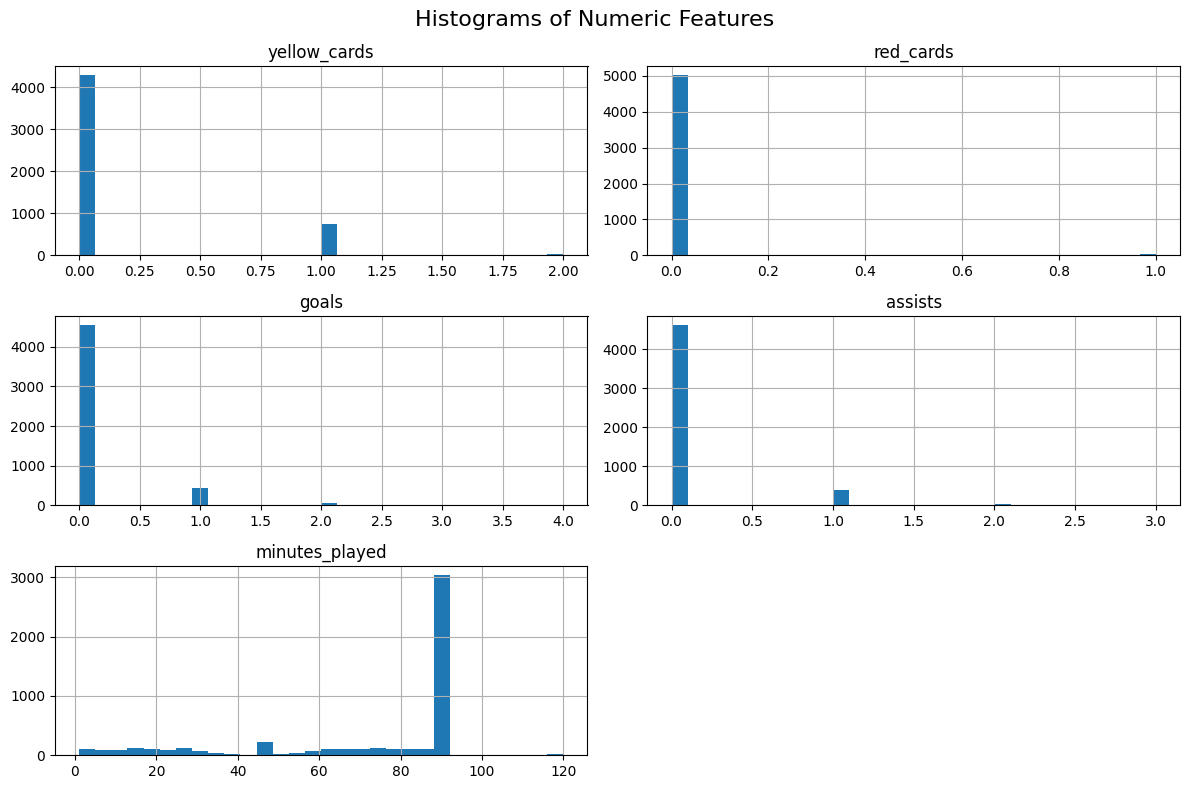

In [8]:
# Histograms of numeric columns
num_cols = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']

df[num_cols].hist(figsize=(12,8), bins=30)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

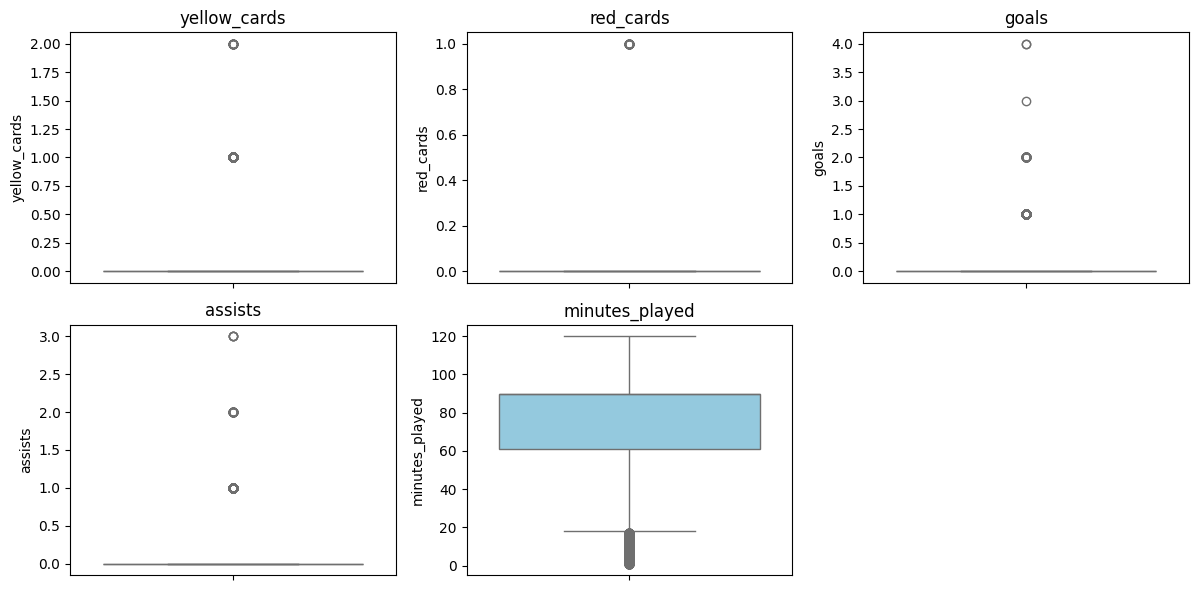

In [9]:
# Boxplots to detect outliers
plt.figure(figsize=(12,6))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df, y=col, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

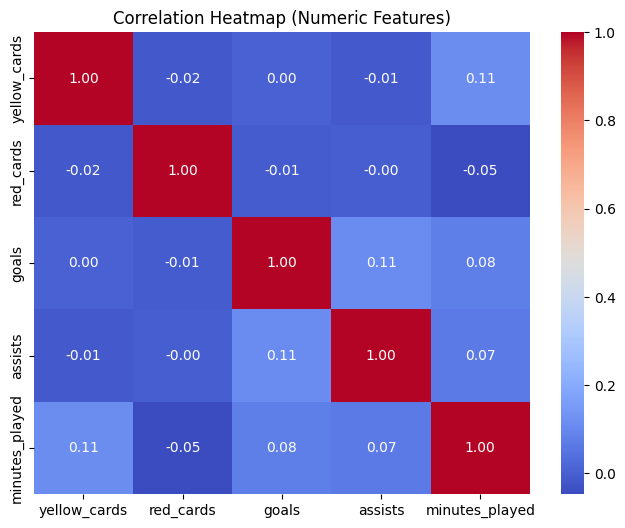

In [10]:
# Correlation Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

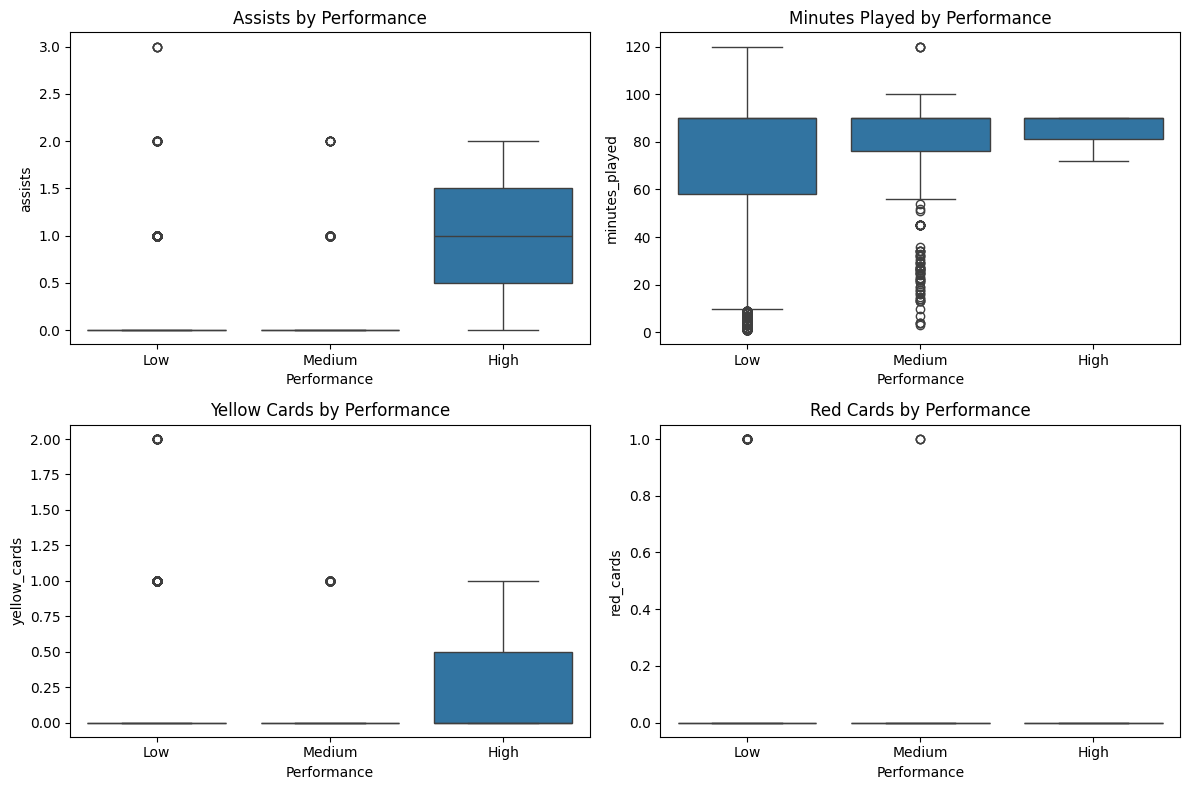

In [11]:
# Performance by features
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.boxplot(data=df, x='Performance', y='assists', order=['Low', 'Medium', 'High'], ax=axes[0,0])
axes[0,0].set_title('Assists by Performance')

sns.boxplot(data=df, x='Performance', y='minutes_played', order=['Low', 'Medium', 'High'], ax=axes[0,1])
axes[0,1].set_title('Minutes Played by Performance')

sns.boxplot(data=df, x='Performance', y='yellow_cards', order=['Low', 'Medium', 'High'], ax=axes[1,0])
axes[1,0].set_title('Yellow Cards by Performance')

sns.boxplot(data=df, x='Performance', y='red_cards', order=['Low', 'Medium', 'High'], ax=axes[1,1])
axes[1,1].set_title('Red Cards by Performance')

plt.tight_layout()
plt.show()

In [12]:
# Features and target
X = df[['yellow_cards', 'red_cards', 'assists', 'minutes_played']]
y = df['Performance']


In [13]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nEncoded classes:", label_encoder.classes_)


Encoded classes: ['High' 'Low' 'Medium']


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 4042
Test set size: 1011


In [15]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
print("\n" + "="*50)
print("FINDING OPTIMAL K FOR KNN...")
print("="*50)


FINDING OPTIMAL K FOR KNN...


In [17]:
# Use sampling for faster computation on large dataset
sample_size = min(10000, len(X_train_scaled))  # Max 10k samples
idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)

X_train_sample = X_train_scaled[idx]
y_train_sample = y_train[idx]

error_rate = []

K=1 completed - Error Rate: 0.1513
K=3 completed - Error Rate: 0.1236
K=5 completed - Error Rate: 0.1048
K=7 completed - Error Rate: 0.1019
K=9 completed - Error Rate: 0.1009
K=11 completed - Error Rate: 0.1009
K=13 completed - Error Rate: 0.1009
K=15 completed - Error Rate: 0.1009
K=17 completed - Error Rate: 0.1009
K=19 completed - Error Rate: 0.1009

Optimal K = 9


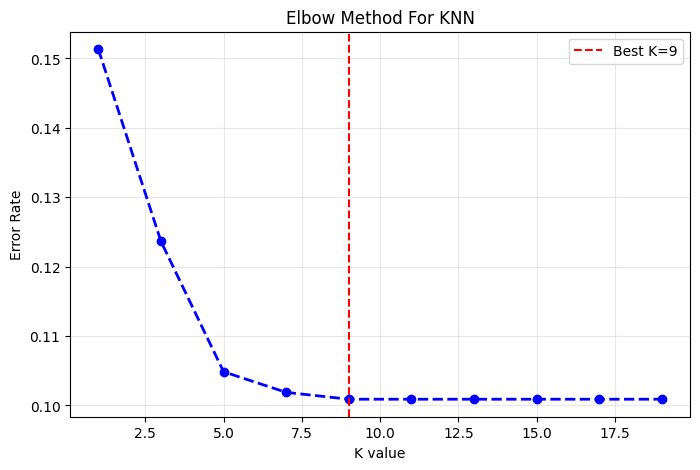

In [18]:
# Test K values from 1 to 20 (every other value for speed)
k_values = range(1, 21, 2)

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_temp.fit(X_train_sample, y_train_sample)
    pred_k = knn_temp.predict(X_test_scaled)
    error_rate.append(np.mean(pred_k != y_test))
    print(f"K={k} completed - Error Rate: {error_rate[-1]:.4f}")

best_k = list(k_values)[error_rate.index(min(error_rate))]
print(f"\nOptimal K = {best_k}")

# -------------------------

plt.figure(figsize=(8,5))
plt.plot(k_values, error_rate, marker='o', linestyle='--', color='blue', linewidth=2)
plt.title("Elbow Method For KNN")
plt.xlabel("K value")
plt.ylabel("Error Rate")
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k}')
plt.legend()
plt.show()

In [19]:
# TRAIN FINAL MODELS
# -------------------------

print("\n" + "="*50)
print("TRAINING FINAL MODELS...")
print("="*50)

# 1. KNN
print("\nTraining KNN...")
knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn.fit(X_train_scaled, y_train)


TRAINING FINAL MODELS...

Training KNN...


KNeighborsClassifier(n_jobs=-1, n_neighbors=9)

In [20]:
# 2. Logistic Regression
print("Training Logistic Regression...")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)


Training Logistic Regression...


LogisticRegression(max_iter=1000, random_state=42)

In [21]:
# 3. SVM
print("Training SVM...")
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_scaled, y_train)


Training SVM...


SVC(kernel='linear', random_state=42)

In [22]:
pred_knn = knn.predict(X_test_scaled)
pred_log = logreg.predict(X_test_scaled)
pred_svm = svm.predict(X_test_scaled)

In [23]:
acc_knn = accuracy_score(y_test, pred_knn)
acc_log = accuracy_score(y_test, pred_log)
acc_svm = accuracy_score(y_test, pred_svm)
print("\n" + "="*50)
print("MODEL ACCURACIES")
print("="*50)
print(f"KNN Accuracy (k={best_k}): {acc_knn:.4f}")
print(f"Logistic Regression Accuracy: {acc_log:.4f}")
print(f"SVM Accuracy: {acc_svm:.4f}")


MODEL ACCURACIES
KNN Accuracy (k=9): 0.8991
Logistic Regression Accuracy: 0.8991
SVM Accuracy: 0.8991


In [24]:
# Best model
best_model_name = max([('KNN', acc_knn), ('Logistic Regression', acc_log),
                       ('SVM', acc_svm)], key=lambda x: x[1])[0]
print(f"\nBest Model: {best_model_name}")


Best Model: KNN


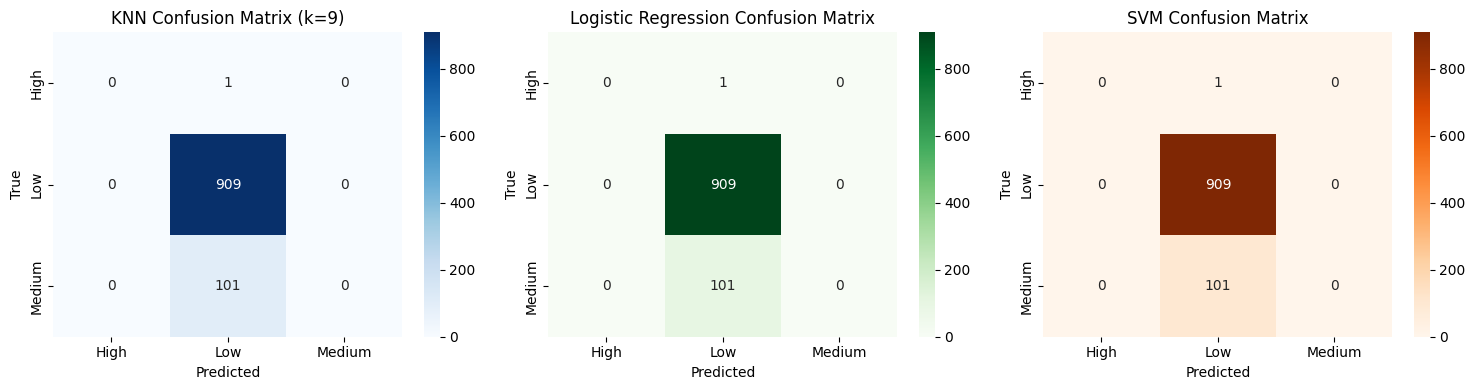

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

# KNN Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title(f'KNN Confusion Matrix (k={best_k})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Logistic Regression Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_log), annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# SVM Confusion Matrix
sns.heatmap(confusion_matrix(y_test, pred_svm), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[2])
axes[2].set_title('SVM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

plt.tight_layout()
plt.show()

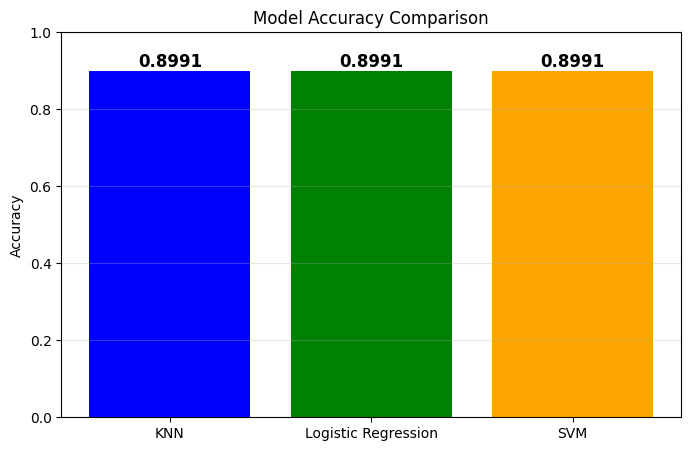

In [26]:
# Model Accuracy Comparison
models = ["KNN", "Logistic Regression", "SVM"]
accuracies = [acc_knn, acc_log, acc_svm]

plt.figure(figsize=(8,5))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

for i, (bar, v) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.01,
             f"{v:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()


In [27]:
print("\n" + "="*50)
print("CLASSIFICATION REPORTS")
print("="*50)

print("\nKNN Classification Report:")
print(classification_report(y_test, pred_knn, target_names=label_encoder.classes_))

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, pred_log, target_names=label_encoder.classes_))

print("\nSVM Classification Report:")
print(classification_report(y_test, pred_svm, target_names=label_encoder.classes_))

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)


CLASSIFICATION REPORTS

KNN Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       0.90      1.00      0.95       909
      Medium       0.00      0.00      0.00       101

    accuracy                           0.90      1011
   macro avg       0.30      0.33      0.32      1011
weighted avg       0.81      0.90      0.85      1011


Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       0.90      1.00      0.95       909
      Medium       0.00      0.00      0.00       101

    accuracy                           0.90      1011
   macro avg       0.30      0.33      0.32      1011
weighted avg       0.81      0.90      0.85      1011


SVM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m